<h1><center>Programming Exercise 3:<br>Multi-class Classification and Neural Networks</center></h1>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.io import loadmat 
from scipy.misc import toimage
from scipy.optimize import fmin_cg, fmin_bfgs, fmin_ncg, fmin_powell
import random

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Multi-class Classification
- Use Logistic Regression (LogR) and Neural Networks (NN) to recognize hadnwritten digits (from 0 to 9)
- In the first part we will extend our previous implemention of LogR and apply it to one vs all classification

## 1.1 Dataset

In [2]:
# Data set in ex3data1.mat contains 5000 training examples of handwritten digits
# We can load .mat file with scipy.io's loadmat
# it returns a dict with variable names as keys, and loaded matrices as values

loadmat('ex3data1.mat')

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data1 = loadmat('ex3data1.mat')
# X is the design matrix of 5000 samples, 400 features for each
# Each sample actually comes from a 20 pixel by 20 pixel image (grayscale) thus comprises a 400-dimensional vector
# y is the output vector with class labels from 1-10; note that the 0 class has been mapped to the number 10 (this is to address an Octave/Matlab indexing issue)
X, y  = data1['X'], data1['y'].flatten() # flatten the second to make it a row vector (as our notational formalism expects)!!

## 1.2 Visualizing the Data
- Randomly select 100 rows from X and display this data together as images

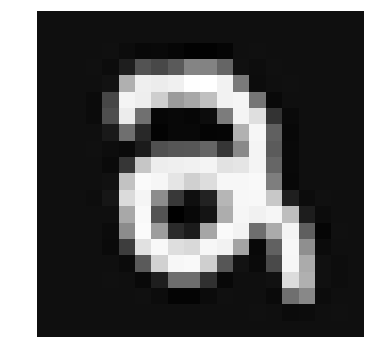

In [4]:
# First let's see how to turn a single sample pixel data into an image
first_sample = X[1111,:]
# Now reshape this into a 20 by 20 2D array
first_sample = np.reshape(first_sample, (20,20))
first_sample = np.flipud(first_sample) # images are upside down so let's flip them
#np.shape(first_sample)

# Can use scipy.misc.toimage to go from numpy array to Python Image Library (PIL) image
first_sample_image = toimage(first_sample) # convert to PIL.Image.Image
first_sample_image = first_sample_image.rotate(270) # Need to rotate them by 270 degrees to get orientation right

# Show image with pyplot.imshow
plt.figure()
plt.imshow(first_sample_image,cmap='Greys_r') # the "_r" bit can reverse any colormap
plt.axis('off')
plt.show()

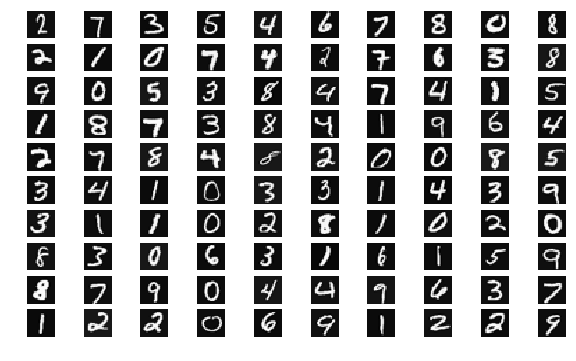

In [5]:
# Select 100 random indices and plot the samples
rand_ind = random.sample(range(0,X.shape[0]),100) # 100 random samples from given population (sequence)

# Save 100 random samples (reshaped into 20 by 20) in array
rand_sample_arr = np.array([np.flipud(np.reshape(X[ii_ind,:],(20,20))) for ii_ind in rand_ind])

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(rand_sample_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.show()

## 1.3 Vectorizing Logistic Regression
- Write regularized cost function and gradient descent (GD) functions
- Meat of the work copied over from last week (ex2.ipynb)

In [2]:
def sigmoid(z):
    '''
    Computes the sigmoid function - the hypothesis for Logistic Regression - given input z
    In the case of Logistic Regression z = X*Theta (which is an m by 1 vector)
    so that H = 1/(1+exp(-X*Theta))
    
    Parameters
    ----------
    z: array
    
    Returns
    -------
    value of sigmoid at the given vector z
    '''
    return 1/(1+np.exp(-z))

def costFunction(theta,design,output,reg_param=0):
    '''
    Computes the cost function J = -1/m{Y^T*Log(g(X*Theta))+(1-Y)^T*Log(1-g(X*Theta))}+lambda/2m{Theta^T*Theta}
    which is a function of Theta for a given sample set; the regularization term is included only if a regularization parameter is passed in 
    X is the design matrix of shape m by (n+1), Theta is the fit (n+1) parameter vector, Y is the m output vector of class labels
    and lambda is the regulatization parameter
    Returns the scalar J
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_param (optional): scalar, regularization parameter; default is 0
    
    Returns
    -------
    costJ: scalar, value of the cost function
    '''
    
    m = np.shape(design)[0] # sample size
    hypothesis = sigmoid(design @ theta)
    costJ = -1/m*(output.T @ np.log(hypothesis)+((1-output).T @ np.log(1-hypothesis)))
    costJ += reg_param/(2*m)*(theta[1:].T @ theta[1:]) # don't regularize the theta0 parameter

    return costJ

def costFunctionGrad(theta,design,output,reg_param=0):
    '''
    Computes the gradient of the regularized logistic regression cost function 
    J = -1/m{Y^T*Log(g(X*Theta))+(1-Y)^T*Log(1-g(X*Theta))}+lambda/2m{Theta^T*Theta} 
    in vectorized form:
    dJ/dTheta_j = 1/m{X^T*{g(X*Theta)-Y}} + (lambda/m)Theta_j for j=0,1,..,n
    (Note: the 0th term does not get regularized)

    The regularization factor will only be added if a regularization parameter is passed in
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_param: scalar, regularization parameter; default is 0
    
    Returns
    ----------
    gradJ: (n+1) vector of gradient of cost function 
    '''
    m = np.shape(design)[0] # sample size
    hypothesis = sigmoid(design @ theta)

    gradJ = 1/m*(design.T @ (hypothesis-output))
    gradJ[1:] += theta[1:]*(reg_param/m) # regularize all other theta's but not theta_0
    
    return gradJ

In [7]:
# Testing with values from ex3.m

test_theta = np.array([-2,-1,1,2])
test_design = np.array([[1,0.1,0.6,1.1],[1,0.2,0.7,1.2],[1,0.3,0.8,1.3],[1,0.4,0.9,1.4],[1,0.5,1,1.5]])
test_output = np.array([1,0,1,0,1])
test_reg_param = 3

# Test
test_cost = costFunction(test_theta,test_design,test_output,reg_param=test_reg_param)
test_gradJ = costFunctionGrad(test_theta,test_design,test_output,reg_param=test_reg_param)
print('Expected Cost Function: 2.534819')
print('Computed Cost Function: {}'.format(test_cost))
print('Expected Cost Function Gradients: [0.146561 -0.548558 0.724722 1.398003]')
print('Computed Cost Function Gradients: {}'.format(test_gradJ))

Expected Cost Function: 2.534819
Computed Cost Function: 2.534819396109744
Expected Cost Function Gradients: [0.146561 -0.548558 0.724722 1.398003]
Computed Cost Function Gradients: [ 0.14656137 -0.54855841  0.72472227  1.39800296]


## 1.4 One-vs-All Classification
- Implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in a dataset; our dataset has $K=10$
- Goal is to train a classifier for each class $y\in\{1,2,3,...,10\}$. That is, for a chosen class (e.g $y=3$) we label all corresponding samples with 1 and all others with 0. Then we minimize the cost function and get the optimal $\theta_k$ for $k\in \{1,...,K\}$ (e.g $\theta_3$)
- This procedure can be done in a for loop covering all $K$ classes. The final result should be a collection of all optimal $\theta$s in a matrix $\Theta\in\mathbb{R}^{K\times(n+1)}$ for $n$ features (+1 for the bias term). The $k$-th row of the matrix will be the optimal fit parameter vector $\theta_k$ for the $k$-th class

In [8]:
# Add bias term to design matrix
X = np.c_[np.ones(X.shape[0]),X]

- The oneVsAll.m script minimizes with a routine known as fmincg where they note "fmincg works similarly to fminunc, but is more efficient when we are dealing with large number of parameters"
- Scipy optimize has this function `scipy.optimize.fmin_cg` which "minimize[s] a function using a nonlinear conjugate gradient algorithm"
    - This function takes in the function to minimize and can also take a function which computes its gradient (if None it does it numerically)

In [9]:
def oneVsAll(design,output,reg_param=0):
    '''
    Optimizes a theta for each of the 10 classes present in the training set separately
    in a one vs. all scheme using scipy.optimize.fmin_cg "conjugate gradient" method.
    
    Parameters
    ----------
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_param: scalar, regularization parameter; default is 0
    
    Returns
    ----------
    theta_matrix: 10 by (n+1) matrix, the kth row corresponds to optimized values for theta of the kth class in one vs. all scheme
    '''
    
    # Now let's allocate space for the final Theta matrix
    # 10 rows for 10 classes, n+1 columns for features plus the bias term
    theta_matrix = np.empty((10,design.shape[1]))
    
    # Initial theta guess of all zeros (same for all classes)
    initial_theta = np.zeros(design.shape[1])
    
    # Loop through classes
    for ii_class in range(10): # ii_class from 0 to 9
        if ii_class == 0: # in dataset class 0 is tagged with the label 10
            ii_class_cut = (output==10).astype(int) # logical cut, bool to int
        else:
            ii_class_cut = (output==ii_class).astype(int) # logical cut, bool to int        
        # Optimize theta
        print('Optimizing theta for class {}'.format(ii_class))
        ii_theta = fmin_cg(costFunction,x0=initial_theta,fprime=costFunctionGrad,args=(X,ii_class_cut,reg_param),maxiter=50,disp=False)
        theta_matrix[ii_class,:] = ii_theta
    print('Finished')
    return theta_matrix

In [10]:
# Optimize thetas
theta_matrix = oneVsAll(X,y,reg_param=0)

Optimizing theta for class 0
Optimizing theta for class 1
Optimizing theta for class 2
Optimizing theta for class 3
Optimizing theta for class 4
Optimizing theta for class 5
Optimizing theta for class 6
Optimizing theta for class 7
Optimizing theta for class 8
Optimizing theta for class 9
Finished


In [11]:
def prediction(theta_matrix,design):
    '''
    Makes prediction of class label in a one-vs-all problem given an optimized parameter matrix theta 
    containing the optimized thetas for each of the 10 classes and a dataset (in the format of the design matrix)
    The prediction is: max(hypothesis_k(x|theta_k)) for all k classes determines class label
    
    Parameters
    ----------
    theta_matrix: 10 by (n+1) matrix, the kth row corresponds to optimized values for theta of the kth class in one vs. all scheme
    design: m by (n+1) design matrix
    
    Returns
    -------
    label: m-dimensional vector of class labels (0-9)
    '''    
    
    # Compute probabilities for all 10 thetas
    # Tranpose theta to get columns of optimized thetas instead of rows so we can perform dot product
    probability_matrix = sigmoid(design @ theta_matrix.T) # of shape m by K=10
    label = np.argmax(probability_matrix,axis=1) # return the index of the highest probability along all columns
                                                 # i.e for every row (each sample), it returns the index of the 
                                                 # highest value which here corresponds to the class label
    
    return label

In [12]:
prediction_label = prediction(theta_matrix,X)
np.shape(prediction_label)

(5000,)

In [13]:
def accuracy(prediction,og_label):
    '''
    Computes percentage accuracy of prediction of class labels by direct comparison to given (original) labels
    in training data set
    
    Parameters
    ----------
    predictions: m-dimensional vector of prediction labels
    og_label: m-dimensional vector of original training labels
    
    Returns
    -------
    acc: scalar, percentage accuracy 
    '''
    m = np.size(og_label)
    np.place(og_label,og_label==10,0) # replace labeled 10's with 0's 
    acc = sum(prediction==og_label)/m # summing True booleans
    return acc 

In [14]:
print('Training accuracy: {:0.1f} %'.format(accuracy(prediction_label,y)*100))

Training accuracy: 89.3 %


- Curious to see what it predicted as what

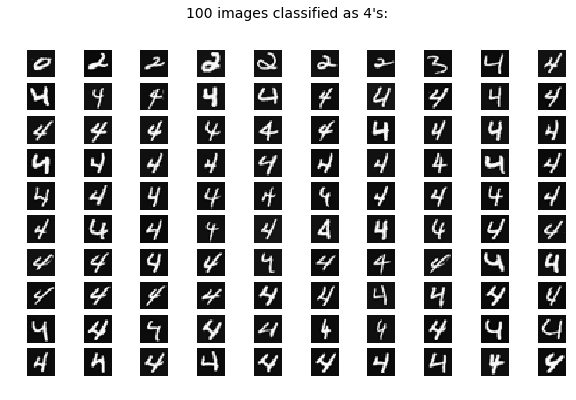

In [15]:
# Let's at some of the images it found to be 4's
predicton_label4_ind = np.argwhere(prediction_label==4).flatten() # there are 519 samples
predicton_label4_ind = predicton_label4_ind[0:100] # Let's take the first hundred so we can use a 10 by 10 figure

# Save 100 random samples (reshaped into 20 by 20) in array
# Ignore the first column (bias) in design matrix for plotting
predicton_label4_arr = np.array([np.flipud(np.reshape(X[ii_ind,1:],(20,20))) for ii_ind in predicton_label4_ind])

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(predicton_label4_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle("100 images classified as 4's:",fontsize=14)
plt.show()

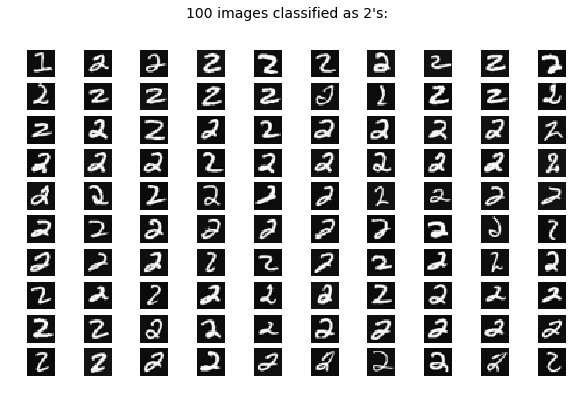

In [16]:
# How about 2's?
predicton_label2_ind = np.argwhere(prediction_label==2).flatten() # there are 519 samples
predicton_label2_ind = predicton_label2_ind[0:100] # Let's take the first hundred so we can use a 10 by 10 figure

# Save 100 random samples (reshaped into 20 by 20) in array
# Ignore the first column (bias) in design matrix for plotting
predicton_label2_arr = np.array([np.flipud(np.reshape(X[ii_ind,1:],(20,20))) for ii_ind in predicton_label2_ind])

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(predicton_label2_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle("100 images classified as 2's:",fontsize=14)
plt.show()

# 2. Neural Networks
- Implement a NN to recognize handwritten digits using the same training set as above
- For this week, we will use parameters from a NN that has already been trained. The goal here is then to implement the feedforward propagation algorithm to use these weights for prediction
    - Next week: write the back propagation algorithm for learning the parameters
- The NN will have 3 layers (input, 1 hidden, output). The first layer will have 401 (20 by 20 pixel plus bias) inputs for every sample (5000 samples total). The hidden layer is chosen to have 25 activation units and is associated with the weights matrix $\Theta^{(1)}$. This means that this matrix will be of shape 25 by 401. Since have a multi class problem we want 10 output units in the output layer. This is associated with a weights matrix $\Theta^{(2)}$ of shape 10 by 26 (=25+1 bias activation unit)
    - Note that as we go from layer $j$ to $j+1$, we associate the transition with a matrix $\Theta^{(j)}_{a\times b}$ where $a$ = # of activation units in layer $j+1$ (before bias term) and $b$ = # of activation units in layer $j$ (after bias). **The shape of $\Theta^{(j)}$ does not depend on the sample size!**
    - For a set of $m$ samples, with a design matrix $X$, to go from the input to the second layer we perform $\Theta^{(1)}\cdot X^T$. The result is the matrix $A^{(2)}=g(\Theta^{(1)}\cdot X^T)$ of shape $a\times m$ where each column belongs to a given sample $i$ and has values $(a^{(2)}_{i,1}$,$a^{(2)}_{i,2},...,a^{(2)}_{i,a})$. We then add a row of 1s at the top to give each sample (column) the bias term and redefine $A^{(2)}$ to be this new matrix of shape $(a+1)\times m$. This matrix holds the final values of all activation units at layer 2 for all samples (a column per sample). To move onto the next sample we take the sigmoid of this and so on...

## 2.1 Model Representation 

In [17]:
# We'll use the same training set as in part 1
# The Theta matrices 1 and 2 are given in ex3weights.mat

data2 = loadmat('ex3weights.mat')

theta1, theta2 = data2['Theta1'], data2['Theta2'] 

# Check shapes
print('theta1 shape is: {}'.format(np.shape(theta1)))
print('theta2 shape is: {}'.format(np.shape(theta2)))

theta1 shape is: (25, 401)
theta2 shape is: (10, 26)


- From our note above we know we're going from (per sample) from 401 inputs (layer 1) to 25+1=26 units (layer 2), to 10 units (layer 3). Thus we expect the shape of $\Theta^{(1)}$ to be $(25\times 401)$ and the shape of $\Theta^{(2)}$ to be $(10\times 26)$ so the shapes are properly formatted!

## 2.2 Feedforward Propagation and Prediction

In [30]:
def predict(theta1,theta2,X):
    '''
    Makes prediction of class label for a three-layer Neural Network with 26 (25+1 bias) activation units
    in second layer (hidden) and 10 units in output later, since there are 10 possible classes {0,1,...,9},
    given the weight matrices of propagation Theta1 and Theta2
    
    Parameters
    ----------
    theta1: 25 by (n+1) matrix of optimized thetas for transition between input layer and hidden layer
    theta2: 10 by (25+1=26) matrix of optimized thetas for transition between hidden layer and output layer
    X: m by (n+1) design matrix 
    
    Returns
    -------
    label: m-dimensional vector of class labels (0-9)
    '''    
    
    # Procedure follows notes in beginning of this section
    m = np.shape(X)[0] # sample size
    a2_matrix = sigmoid(theta1 @ X.T) # initial layer 2 activation units 
    bias_row = np.ones((1,m)) # bias term for second layer activation
    a2_matrix = np.vstack((bias_row,a2_matrix)) # insert bias term
    prob_matrix = sigmoid(theta2 @ a2_matrix) # Since this is the output, no bias term needs to be added for further computation
                                              # This is the matrix of probabilities, each colum for a sample
                                              # and a row for each class 0-9
    prob_matrix = np.roll(prob_matrix,1,axis=0) # shift entries in each column by 1, i.e colum [1,2,3] becomes [3,2,1]
                                                # see note below
    label = np.argmax(prob_matrix,axis=0) # return the index of the highest probability along all rows
                                          # i.e for every column (each sample), it returns the index of the 
                                          # highest value which here corresponds to the class label
    return label

- The output of forward propagation will give a matrix $a^{(3)}$ where the probabilities of a sample $i$ belonging to one of the 10 classes are the rows of the $i^{\text{th}}$ column: $a^{(3)}_{:,i}=[a^{(3)}_{i,1},a^{(3)}_{i,2},...,a^{(3)}_{i,10}]$. That is, the probability of the sample belonging to class, say 1, is given by $a^{(3)}_{i,1}$. Note that while we do have 10 total classes we are looking to classify the image of a digit that will be labeled as 0, 1, 2, ..., or 9. In Python we begin indexing with 0, thus if we want to interpret the 0th value of column $i$ of $a^{(3)}$ as the probability that sample $i$ is digit $i\in\{0,1,2,...,9\}$ then we need to roll the values so that column $i$ is instead $a^{(3)}_{:,i}=[a^{(3)}_{i,10},a^{(3)}_{i,1},...,a^{(3)}_{i,9}]$ because the dataset has been supplied with the assumption that "0" digits have been labeled "10" and thus the weights of the $\Theta$ matrices corresponding to this feature have also been set as the last entries rather than the first. Now that we have rolled the indices, the interpretation of probabilities for images of digits being classified as 0, 1, 2, ..., or 9 is clear

In [26]:
prediction_label = predict(theta1,theta2,X)
prediction_label.shape

(5000,)

In [27]:
np.unique(prediction_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [29]:
# Use the accuracy function from section 1 to see how good the NN is
# Can do a direct comparison since we already replaced the 10's in y to 0's
print('Training accuracy: {:0.2f} %'.format(accuracy(prediction_label,y)*100))

Training accuracy: 97.52 %


- Great results, now let's plot some of the predictions:

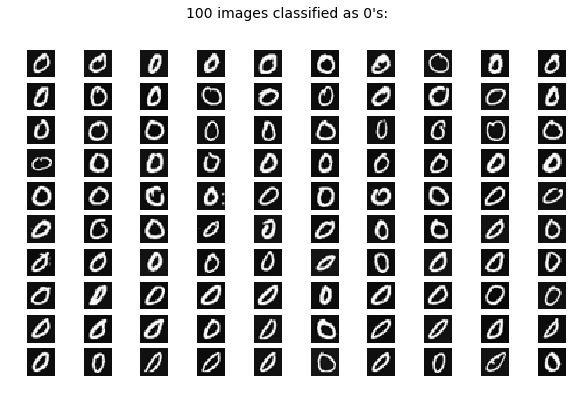

In [23]:
# Let's at some of the images it found to be 0's
predicton_label0_ind = np.argwhere(prediction_label==0).flatten() # there are 519 samples
predicton_label0_ind = predicton_label0_ind[0:100] # Let's take the first hundred so we can use a 10 by 10 figure

# Save 100 random samples (reshaped into 20 by 20) in array
# Ignore the first column (bias) in design matrix for plotting
predicton_label0_arr = np.array([np.flipud(np.reshape(X[ii_ind,1:],(20,20))) for ii_ind in predicton_label0_ind])

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(predicton_label0_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle("100 images classified as 0's:",fontsize=14)
plt.show()

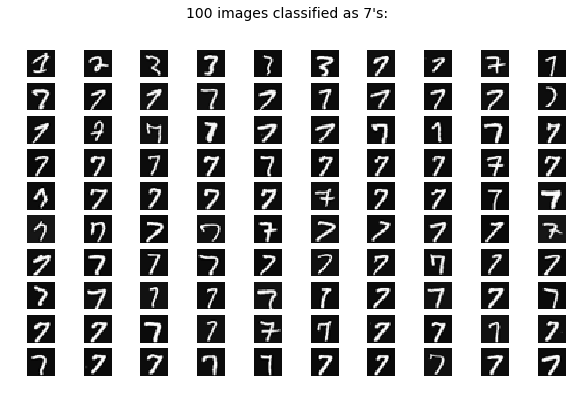

In [24]:
# How about 7's?
predicton_label7_ind = np.argwhere(prediction_label==7).flatten() # there are 519 samples
predicton_label7_ind = predicton_label7_ind[0:100] # Let's take the first hundred so we can use a 10 by 10 figure

# Save 100 random samples (reshaped into 20 by 20) in array
# Ignore the first column (bias) in design matrix for plotting
predicton_label7_arr = np.array([np.flipud(np.reshape(X[ii_ind,1:],(20,20))) for ii_ind in predicton_label7_ind])

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(predicton_label7_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.suptitle("100 images classified as 7's:",fontsize=14)
plt.show()